In [91]:
import math
import random
import copy
import matplotlib.pyplot as plt

# Any Colony Optimization

1. class for customer(node) and vehicle(route)

In [92]:
class Node():
    def __init__(self,id,x,y,weight):
        self.id = id
        self.x = x
        self.y = y
        self.weight = weight

class Route():
    def __init__(self,start,Capacity):
        self.start = start
        self.Capacity = Capacity
        self.load = 0
        self.route = []
            
    def currentnode(self):
        if len(self.route) == 0:
            return self.start # To be modified
        return self.route[-1]

    def addnode(self, node):
        self.route.append(node)
        self.load = self.load + node.weight

    # def node_distance(self,A,B):
    #     return math.sqrt((A.x-B.x)**2 + (A.y-B.y)**2)
    
    # call function node_distance, defined outside the class
    def route_length(self): # must be non-empty
        length = 0
        length += node_distance(self.route[0],self.start)# Add the distance from the start to the first node
        for i in range(len(self.route)-1):
            length += node_distance(self.route[i],self.route[i+1])
        length += node_distance(self.route[-1],self.start)# Add the distance from the last node to the start node
        return length
    
    def CheckCapacity(self):
        if self.load > self.Capacity:
            return False
        else:
            return True
        
    def Checkempty(self):
        if len(self.route) == 0:
            return False
        else:
            return True
        
class RoutePlan():
    def __init__(self, start, Capacity):
        self.start = start
        self.routeplan = []
        self.Capacity = Capacity
    
    def addroute(self,route):
        self.routeplan.append(route)

    def RP_distance(self):
        distance = 0
        for i in range(len(self.routeplan)):
            distance += self.routeplan[i].route_length()
        return distance
    def ReturnNodes(self):
        nodes = []
        for route in self.routeplan:
               for node in route.route:
                   nodes.append(node.id)
        return nodes

2. Route Distance

In [93]:
# 3.1 Distance of a specific route.
def node_distance(A,B):
    return math.sqrt((A.x-B.x)**2 + (A.y-B.y)**2)
# 3.2 Calculate the distance matrix of all nodes
def distance_matrix(Nodes):
    n = len(Nodes)
    matrix = [[0 for i in range(n)] for j in range(n)]
    for i in range(n):
        for j in range(n):
            matrix[i][j] = node_distance(Nodes[i],Nodes[j])
    return matrix

In [94]:
# Generate N customers with weights between MINweight and MAXweight
def Generate_Nodes(N,MINweight,MAXweight):
    Nodes = []
    data = list(set((random.randrange(900), random.randrange(600))for c in range(N)))
    for i in range(N):
        node_i = Node(i+1,data[i][0],data[i][1],random.randrange(MINweight,MAXweight))
        Nodes.append(node_i)
    return Nodes

3. Update Next visit

In [95]:
# 1.1 Next Visit Set
def Next_Node_Set(RP,NodeSet):
    # Three possible scenarios:
    # 1. No node has been visited
    Nodes = copy.deepcopy(NodeSet)
    if len(RP.routeplan) == 0:
        RP.addroute(Route(RP.start,RP.Capacity)) #ensure that the routeplan is not empty
        return Nodes
    # 2. Some nodes have been visited, and the last route is not full
    #visited = flat([route.route for route in RP.routeplan])
    visited = RP.ReturnNodes()
    route = RP.routeplan[-1]
    unvisited = [node for node in Nodes if node.id not in visited and route.load + node.weight <= route.Capacity]
    # 3. Some nodes have been visited, and the last route is full
    if len(unvisited) == 0:
        unvisited = [node for node in Nodes if node.id not in visited]
        RP.addroute(Route(RP.start,RP.Capacity))
    return unvisited

# 1.2 Next Visit node
# return next visit node, meanwhile remove it from unvisited
def Next_node(RP,unvisited,Eta,Tau,alpha,beta):
    route = RP.routeplan[-1] # RP is not empty after calling Next_Node_Set
    currentNode = route.currentnode() # if route is empty, currentNode is the start node by definition
    p_ij = [0 for i in range(len(unvisited))]
    for j,node in enumerate(unvisited):
        p_ij[j] = (Tau[currentNode.id][node.id])**alpha * (Eta[currentNode.id][node.id])**beta
    p_ij = [p/sum(p_ij) for p in p_ij]
    index = roulette(p_ij) # To be defined
    return unvisited.pop(index)

def roulette(p_ij):
    r = random.random() + 1e-10 # avoid r = 0 so that the start node can be selected
    for i in range(len(p_ij)):
        if sum(p_ij[:i+1]) >= r:
            return i
        
def updateTau(Tau,rho,Q,RP):
    delta_tau = Q/RP.RP_distance()
    Delta_tau = [[0 for i in range(len(Tau))] for j in range(len(Tau))]
    for route in RP.routeplan:
        Delta_tau[route.start.id][route.route[0].id] += delta_tau
        Delta_tau[route.route[0].id][route.start.id] += delta_tau
        #Tau[0][route.route[0].id] = rho*Tau[0][route.route[0].id] + Delta_tau[0][route.route[0].id]
        for i in range(len(route.route)-1):
            Delta_tau[route.route[i].id][route.route[i+1].id] += delta_tau
            Delta_tau[route.route[i+1].id][route.route[i].id] += delta_tau
            #Tau[route.route[i].id][route.route[i+1].id] = (1-rho)*Tau[route.route[i].id][route.route[i+1].id] + Delta_tau[route.route[i].id][route.route[i+1].id]
        Delta_tau[route.route[-1].id][route.start.id] += delta_tau
        Delta_tau[route.start.id][route.route[-1].id] += delta_tau
        #Tau[route.route[-1].id][0] = rho*Tau[route.route[-1].id][0] + Delta_tau[route.route[-1].id][0]
    for i in range(len(Tau)):
        for j in range(len(Tau)):
            Tau[i][j] = (1-rho)*Tau[i][j] + Delta_tau[i][j]
    return Tau

4. Main Function

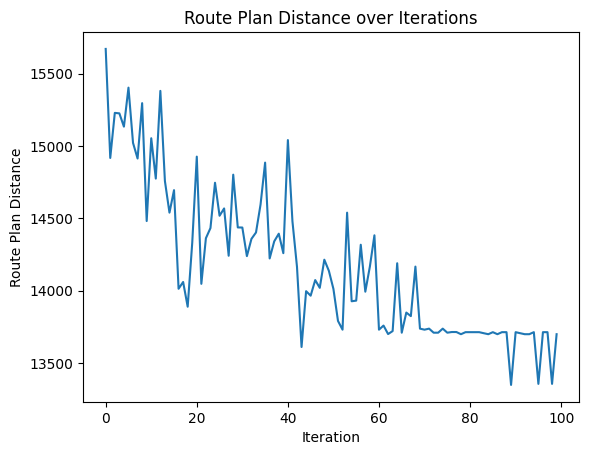

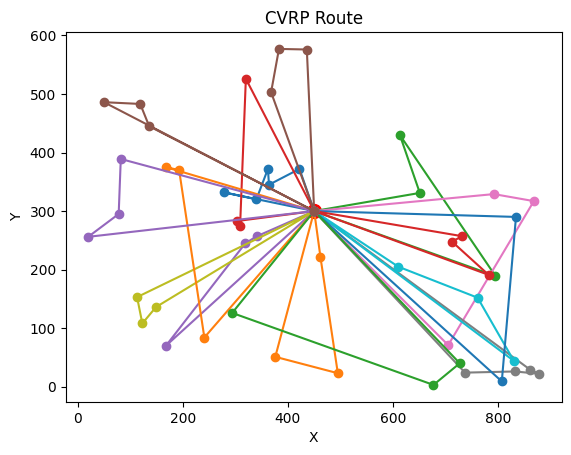

In [96]:
N = 50     
other_Nodes = Generate_Nodes(N,10,50)
start = Node(0,450,300,0)
Nodes = [start] + other_Nodes
distance_matrix = distance_matrix(Nodes)
m = 10
Q = 50
alpha = 1
beta = 3
eta = [[1/i if i != 0 else 0 for i in distance] for distance in distance_matrix] #distance_matrix main diagonal is 0, cause error

max_iter = 100
rho = 0.5
Tau = [[1 for i in range(len(Nodes))] for j in range(len(Nodes))]
Capacity = 100
RP = RoutePlan(start,Capacity)


best_RP = []
for iter in range(max_iter):
    rps = []
    for i in range(m): # for each ant
        rp = copy.deepcopy(RP)
        unvisited = other_Nodes
        while len(rp.ReturnNodes()) != N:
            unvisited = Next_Node_Set(rp,other_Nodes)
            next_node = Next_node(rp,unvisited,eta,Tau,alpha,beta)
            rp.routeplan[-1].addnode(next_node)
        rps.append(rp)
        # if sorted(rp.ReturnNodes()) != list(range(1,11)):
        #     print(rp.ReturnNodes())
    best_rp = min(rps,key = lambda x : x.RP_distance()) #best route plan in the current iteration
    updateTau(Tau,rho,Q,best_rp)
    best_RP.append(best_rp)

iterations = [rp.RP_distance() for rp in best_RP]
plt.plot(iterations)
plt.xlabel('Iteration')
plt.ylabel('Route Plan Distance')
plt.title('Route Plan Distance over Iterations')
plt.show()

best_rp = best_RP[-1]
plt.plot(start.x,start.y,'ro',markersize=10)
for route in best_rp.routeplan:
    x = [start.x] + [node.x for node in route.route] + [start.x]
    y = [start.y] + [node.y for node in route.route] + [start.y]
    plt.plot(x, y, marker='o')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('CVRP Route')
plt.show()